In [1]:
import sys
import numpy as np
import time
from explauto.utils import rand_bounds
sys.path.append('../')

from cogsci2017.environment.arm_diva_env import CogSci2017Environment
%matplotlib inline
import matplotlib.pyplot as plt

env_audio = CogSci2017Environment(audio=True)
env = CogSci2017Environment()


# Define Vowels and triplets
v_o = list(np.log2([500, 900]))
v_y = list(np.log2([300, 1700]))
v_u = list(np.log2([300, 800]))
v_e = list(np.log2([400, 2200]))
v_i = list(np.log2([300, 2300]))
#v_a = list(np.log2([800, 1300]))

vowels = dict(o=v_o, y=v_y, u=v_u, e=v_e, i=v_i)
                     
def check_sounds(s_traj, tol=0.25):    
    if s_traj is None:
        return "NNN"
    s1 = s_traj[0]
    s2 = s_traj[24]
    s3 = s_traj[-1]
    
    v1 = "N"
    v2 = "N"
    v3 = "N"
    
    for v in vowels.keys():
        if abs(s1[0]-vowels[v][0]) < tol and abs(s1[1]-vowels[v][1]) < tol:
            v1 = v
        if abs(s2[0]-vowels[v][0]) < tol and abs(s2[1]-vowels[v][1]) < tol:
            v2 = v
        if abs(s3[0]-vowels[v][0]) < tol and abs(s3[1]-vowels[v][1]) < tol:
            v3 = v
    
    sound = v1 + v2 + v3
    
    return sound

human sounds ['uye', 'eou', 'iuo', 'yeo', 'eyu', 'oey']
human sounds ['uye', 'iuo', 'eou', 'oey', 'yeo', 'eyu']


(array([-10.22881869]), array([-7.64385619]))

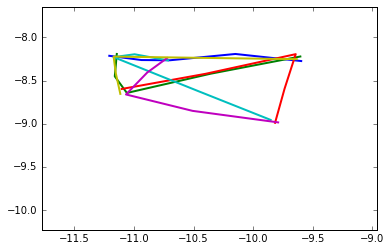

In [2]:
human_sounds = ["uyi", "ieu", "euo", "oiy", "oey", "uie"]

def compute_s_sound(sound):
    s1 = vowels[sound[0]]
    s2 = [(vowels[sound[0]][0] + vowels[sound[1]][0]) / 2., (vowels[sound[0]][1] + vowels[sound[1]][1]) / 2.]
    s3 = vowels[sound[1]]
    s4 = [(vowels[sound[1]][0] + vowels[sound[2]][0]) / 2., (vowels[sound[1]][1] + vowels[sound[2]][1]) / 2.]
    s5 = vowels[sound[2]]
    rdm = 0.05 * (2.*np.random.random((1,10))[0] - 1.)
    return list(rdm + np.array([f[0] for f in [s1, s2, s3, s4, s5]] + [f[1] for f in [s1, s2, s3, s4, s5]]))


human_sounds_traj = dict()
human_sounds_traj_std = dict()
for hs in human_sounds:
    human_sounds_traj[hs] = compute_s_sound(hs)
    human_sounds_traj_std[hs] = human_sounds_traj[hs]
    human_sounds_traj_std[hs] = [d - 8.5 for d in human_sounds_traj[hs][:5]] + [d - 10.25 for d in human_sounds_traj[hs][5:]]    
    plt.plot(- np.array(human_sounds_traj[hs][5:]), -np.array(human_sounds_traj[hs][:5]), lw=2)
    
plt.xlim([-np.log2([3500.]), -np.log2([500.])])
plt.ylim([-np.log2([1200.]), -np.log2([200.])])

In [2]:
from cogsci2017.learning.supervisor import Supervisor



def train(n_motor_babbling=100, n_goal_babbling=900, n_imitation_each=500, explo_noise=0.1):
    
    m_list = []
    sound_list = []
    sound_dict = {}
    vowels_dict = {}
    iteration = 0
    
    s_traj_mb_list = []
    s_traj_gb_list = []
    s_traj_im_list = []

    config = dict(m_mins=env.conf.m_mins,
                 m_maxs=env.conf.m_maxs,
                 s_mins=env.conf.s_mins,
                 s_maxs=env.conf.s_maxs)

    agent = Supervisor(config, explo_noise=explo_noise)
    

    for i in range(n_motor_babbling + n_goal_babbling):
        if i < n_motor_babbling:
            m = agent.motor_babbling(audio=True)
        else:
            context = env.get_current_context()
            m = agent.produce(context)
            
        s = env.update(m)
        agent.perceive(s)

        m_list.append(m)
        s_traj = env.diva_traj
        
        if s_traj is not None:

            sound = check_sounds(s_traj)
            sound_list.append(sound)
            if sound_dict.has_key(sound):
                sound_dict[sound] += [iteration]
            else:
                sound_dict[sound] = [iteration]
            for v in vowels:
                if v in sound:
                    if vowels_dict.has_key(v):
                        vowels_dict[v] += [iteration]
                    else:
                        vowels_dict[v] = [iteration]
            if i < n_motor_babbling:
                plt.plot([-f[1] for f in s_traj], [-f[0] for f in s_traj], color="r", alpha=0.2)
                s_traj_mb_list.append(s_traj)
            else:
                plt.plot([-f[1] for f in s_traj], [-f[0] for f in s_traj], color="g", alpha=0.2)
                s_traj_gb_list.append(s_traj)
        iteration += 1
           
    results_errors = {}
    results_sounds = {}
    results_it = {}

    for hs in env.human_sounds:
        results_errors[hs] = []
        results_sounds[hs] = []
        results_it[hs] = -1 

    for hs in env.human_sounds:
        #IMITATE
        #best_sound_list, error_list = train_imitation(agent, hs, iterations=n_imitation_each, explo_noise=explo_noise)

        m = agent.modules["mod13"].inverse(np.array(env.human_sounds_traj_std[hs]), explore=False) 
        s = env.update([0.]*21 + list(m))
        s_traj = env.diva_traj
        best_error = np.linalg.norm(np.array(env.human_sounds_traj[hs]) - np.array([f[0] for f in s_traj[[0, 12, 24, 37, 49]]] + [f[1] for f in s_traj[[0, 12, 24, 37, 49]]]))
        best_sound = check_sounds(s_traj)
        #print "best error", best_error
        #print "s_traj", s_traj, human_sounds_traj[hs]
        error_list = []
        best_sound_list = []

        for i in range(n_imitation_each):
            #print env.get_current_context()
            m = agent.modules["mod13"].inverse(np.array(env.human_sounds_traj_std[hs]), explore=True) 
            agent.m = [0.]*21 + list(m)
            s = env.update(agent.m)
            agent.perceive(s)
            s_traj = env.diva_traj


            m_list.append(m)
            if s_traj is not None:
                s_traj_im_list.append(s_traj)

                sound = check_sounds(s_traj)
                sound_list.append(sound)
                if sound_dict.has_key(sound):
                    sound_dict[sound] += [iteration]
                else:
                    sound_dict[sound] = [iteration]
                for v in vowels:
                    if v in sound:
                        if vowels_dict.has_key(v):
                            vowels_dict[v] += [iteration]
                        else:
                            vowels_dict[v] = [iteration]
            # Error
            error = np.linalg.norm(np.array(env.human_sounds_traj[hs]) - np.array([f[0] for f in s_traj[[0, 12, 24, 37, 49]]] + [f[1] for f in s_traj[[0, 12, 24, 37, 49]]]))

            if error < best_error:
                best_error = error
                best_sound = sound
            error_list += [best_error]
            best_sound_list += [best_sound]
            iteration += 1
        

            #plt.plot(-s_traj[0][1], -s_traj[0][0], "ok", alpha=0.2)
            plt.plot([-f[1] for f in s_traj], [-f[0] for f in s_traj], color="b", alpha=0.2)
        print "end best error for sound", hs, best_error

        # Human Sound
        #plt.plot(- np.array(human_sounds_traj[hs][5:])[0], -np.array(human_sounds_traj[hs][:5][0]), "ok")
        #plt.plot(- np.array(human_sounds_traj[hs][5:]), -np.array(human_sounds_traj[hs][:5]), lw=3)



        #plt.xlim([-np.log2([3500.]), -np.log2([500.])])
        #plt.ylim([-np.log2([1200.]), -np.log2([100.])])
    
        
        
        
        results_sounds[hs] += best_sound_list
        results_errors[hs] += error_list
        try:
            results_it[hs] = results_sounds[hs].index(hs)
        except ValueError:
            results_it[hs] = -1
    
    
    plt.xlim([-np.log2([3500.]), -np.log2([500.])])
    plt.ylim([-np.log2([1200.]), -np.log2([200.])])
    for v in vowels.keys():
        plt.plot(-vowels[v][1], -vowels[v][0], "o")

    print
    for key in sound_dict.keys():
        if not (key[0] == "N" or key[1] == "N" or key[2] == "N"):
            print "Sound:", key, "  Iterations: ", sound_dict[key]
    print
    for v in vowels:
        if vowels_dict.has_key(v):
            print "Vowel [", v, "] played", len(vowels_dict[v]), "times"

    def listen(i):
        print "Playing sound: ", sound_list[i], "of iteration ", i
        m = m_list[i]
        env_audio.diva.update(m[21:])

    def listen_triplets():
        for key in sound_dict.keys():
            if not (key[0] == "N" or key[1] == "N" or key[2] == "N"):
                for i in sound_dict[key]:
                    listen(i)
                    time.sleep(1)
            
                    
    return results_sounds, results_errors, results_it, s_traj_mb_list, s_traj_gb_list, s_traj_im_list

best_vocal_errors [('uye', 0.64113742174741939), ('yeo', 0.60589808066566775), ('eyu', 0.50411176516890943), ('iuo', 0.74800026259924424), ('eou', 0.67202409021992104), ('oey', 0.58732148923730676)]

----------------
Agent Statistics
----------------

#Iterations: 1000

# Chosen module mod1 : 0
# Chosen module mod2 : 0
# Chosen module mod3 : 0
# Chosen module mod4 : 0
# Chosen module mod5 : 0
# Chosen module mod6 : 0
# Chosen module mod10 : 0
# Chosen module mod11 : 0
# Chosen module mod12 : 0
# Chosen module mod13 : 0

Competence progress of mod1  :  0.0
Competence progress of mod2  :  0.0
Competence progress of mod3  :  0.0
Competence progress of mod4  :  0.0
Competence progress of mod5  :  0.0
Competence progress of mod6  :  0.0
Competence progress of mod10 :  0.0
Competence progress of mod11 :  0.0
Competence progress of mod12 :  0.0
Competence progress of mod13 :  0.0

Prediction progress of mod1  :  0.0
Prediction progress of mod2  :  0.0
Prediction progress of mod3  :  0.0
Predi

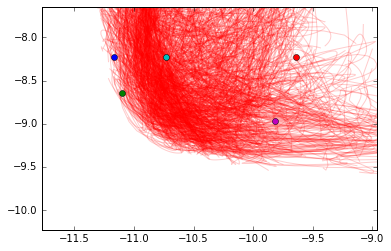

In [6]:
c1_sounds, c1_errors, c1_it, s_traj_mb_list, _, _ = train(n_motor_babbling=1000, n_goal_babbling=0, n_imitation_each=0, explo_noise=0.1)

end best error for sound uyi 0.732597155006
end best error for sound ieu 0.910971515514
end best error for sound euo 0.61524897219
end best error for sound oiy 0.678920306363
end best error for sound oey 0.582903828124
end best error for sound uie 0.829317317763

Sound: yee   Iterations:  [1152]
Sound: yey   Iterations:  [1707]
Sound: eee   Iterations:  [98]
Sound: ouo   Iterations:  [1894]
Sound: oue   Iterations:  [737]
Sound: ouy   Iterations:  [220, 1699]
Sound: ouu   Iterations:  [688, 1282, 1943]
Sound: oey   Iterations:  [826]
Sound: euo   Iterations:  [345]
Sound: yuo   Iterations:  [1266, 1483]
Sound: yyu   Iterations:  [1335, 1912]
Sound: yyy   Iterations:  [1264]
Sound: yyo   Iterations:  [800, 870]
Sound: ooo   Iterations:  [1180, 1514]
Sound: oyy   Iterations:  [409, 959, 993, 1075]
Sound: oyu   Iterations:  [731]
Sound: yoy   Iterations:  [774, 873]
Sound: you   Iterations:  [1786]
Sound: ioy   Iterations:  [439]
Sound: uyi   Iterations:  [392]

Vowel [ i ] played 68 time

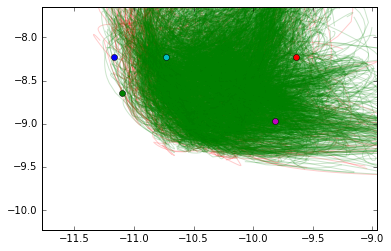

In [35]:
c2_sounds, c2_errors, c2_it = train(n_motor_babbling=250, n_goal_babbling=1750, n_imitation_each=0, explo_noise=0.1)

end best error for sound uyi 0.401421789974
end best error for sound ieu 0.608394057659
end best error for sound euo 0.492207890657
end best error for sound oiy 0.564910936046
end best error for sound oey 0.348981735912
end best error for sound uie 0.332158944908

Sound: ieo   Iterations:  [861, 892, 898, 903, 915, 916, 931, 934, 947, 949, 951, 963, 965, 966, 971, 975, 978, 985, 987, 990, 994]
Sound: uoo   Iterations:  [322]
Sound: eeo   Iterations:  [871, 873, 884, 943, 959, 984, 999]
Sound: uei   Iterations:  [657, 1656, 1758, 1775, 1877, 1879, 1923]
Sound: uee   Iterations:  [648, 1801, 1845]
Sound: uey   Iterations:  [580, 1730]
Sound: oii   Iterations:  [1546, 1574]
Sound: oey   Iterations:  [1536, 1547, 1549, 1579, 1625, 1628, 1646, 1661, 1712, 1731]
Sound: euo   Iterations:  [1085, 1167]
Sound: oei   Iterations:  [1576, 1713, 1733]
Sound: oee   Iterations:  [1599, 1616]
Sound: yeo   Iterations:  [800, 801, 804, 811]
Sound: yyy   Iterations:  [92, 237, 790]
Sound: uie   Iteration

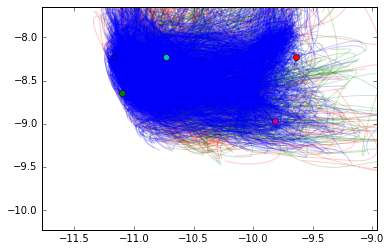

In [36]:
c3_sounds, c3_errors, c3_it = train(n_motor_babbling=250, n_goal_babbling=250, n_imitation_each=250, explo_noise=0.1)

In [37]:
c3_it

{'euo': -1, 'ieu': -1, 'oey': 47, 'oiy': -1, 'uie': -1, 'uyi': 60}

end best error for sound uyi 0.42115049975
end best error for sound ieu 0.418907944054
end best error for sound euo 0.48966005555
end best error for sound oiy 0.379668253512
end best error for sound oey 0.380378079235
end best error for sound uie 0.354519124834

Sound: yey   Iterations:  [161, 386]
Sound: euy   Iterations:  [484]
Sound: uoo   Iterations:  [411]
Sound: uee   Iterations:  [139, 1807, 1952]
Sound: uey   Iterations:  [585, 712]
Sound: oey   Iterations:  [1273, 1277, 1279, 1283, 1297, 1299, 1300, 1318, 1349, 1371, 1373, 1392, 1416, 1426, 1472, 1477, 1480, 1506, 1516, 1522, 1551, 1558, 1566, 1584, 1589, 1600, 1612, 1634, 1635, 1645, 1664, 1669, 1673, 1744, 1746, 1747]
Sound: oei   Iterations:  [1509, 1595, 1643, 1671, 1685, 1742]
Sound: oee   Iterations:  [32, 1295, 1298, 1308, 1321, 1325, 1335, 1337, 1341, 1357, 1362, 1375, 1378, 1429, 1490, 1500, 1502, 1511, 1518, 1525, 1526, 1532, 1538, 1548, 1552, 1557, 1568, 1571, 1576, 1581, 1599, 1603, 1604, 1615, 1620, 1622, 1636, 16

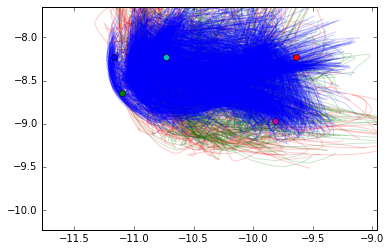

In [38]:
c3_sounds, c3_errors, c3_it = train(n_motor_babbling=250, n_goal_babbling=250, n_imitation_each=250, explo_noise=0.05)

In [39]:
c3_it

{'euo': -1, 'ieu': -1, 'oey': 0, 'oiy': -1, 'uie': 0, 'uyi': 217}

end best error for sound uyi 0.457412925238
end best error for sound ieu 0.548562308157
end best error for sound euo 0.329180399252
end best error for sound oiy 0.390295509861
end best error for sound oey 0.375213783907
end best error for sound uie 0.412268727493

Sound: ieu   Iterations:  [1431]
Sound: euu   Iterations:  [1784, 1821, 1879, 1922, 1926]
Sound: oyi   Iterations:  [273, 955, 2296]
Sound: uei   Iterations:  [721, 741, 780, 3028, 3332]
Sound: uee   Iterations:  [3067, 3072, 3099, 3109, 3122, 3221, 3296, 3328, 3439, 3442]
Sound: uey   Iterations:  [734, 791, 931, 936, 2027, 2372, 2589, 3013]
Sound: oii   Iterations:  [2041, 2064, 2130, 2245, 2461, 2561, 3043, 3179]
Sound: oey   Iterations:  [2056, 2068, 2078, 2106, 2132, 2136, 2146, 2511, 2527, 2563, 2569, 2573, 2587, 2632, 2643, 2645, 2656, 2692, 2699, 2704, 2720, 2742, 2770, 2819, 2821, 2824, 2829, 2845, 2868, 2877, 2944, 2945, 2955]
Sound: euo   Iterations:  [1587, 1717, 1748, 1753, 1793, 1799, 1807, 1825, 1829, 1840, 185

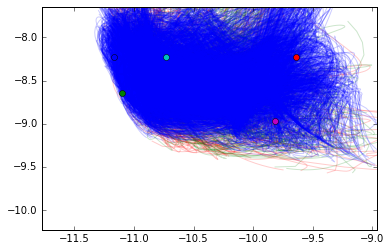

In [40]:
c3_sounds, c3_errors, c3_it = train(n_motor_babbling=250, n_goal_babbling=250, n_imitation_each=500, explo_noise=0.1)

In [41]:
c3_it

{'euo': 217, 'ieu': 431, 'oey': -1, 'oiy': 38, 'uie': -1, 'uyi': 4}

end best error for sound uyi 0.272880995759
end best error for sound ieu 0.383104273921
end best error for sound euo 0.414489289958
end best error for sound oiy 0.484773787862
end best error for sound oey 0.386567506598
end best error for sound uie 0.328121268776

Sound: yey   Iterations:  [2361]
Sound: yeu   Iterations:  [1542, 1577, 1628, 1630, 1631, 1647, 1651, 1655, 1683, 1688, 1698, 1701, 1713, 1728, 1752, 1760, 1767, 1769, 1786, 1983, 1988, 2036, 2039, 2054, 2077, 2131, 2167, 2174, 2179, 2189, 2190, 2191, 2200, 2228, 2229, 2231, 2243, 2254, 2263, 2269, 2295, 2296, 2299, 2306, 2332, 2335, 2372, 2380, 2383, 2384, 2385, 2389, 2391, 2404, 2408, 2413, 2414, 2416, 2421, 2431, 2432, 2435, 2438, 2449, 2453, 2457, 2458, 2464, 2468, 2481, 2494]
Sound: iey   Iterations:  [1889, 2133, 2186]
Sound: uoy   Iterations:  [521]
Sound: ieu   Iterations:  [1578, 1607, 1616, 1692, 1703, 1740, 1759, 1771, 1793, 1805, 1806, 1817, 1824, 1825, 1854, 1858, 1866, 1884, 1886, 1908, 1924, 1961, 1967, 1976, 1

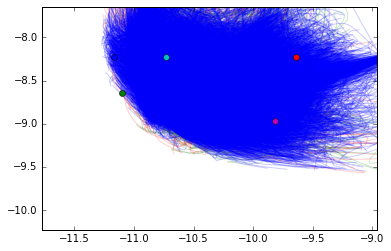

In [42]:
c3_sounds, c3_errors, c3_it = train(n_motor_babbling=250, n_goal_babbling=250, n_imitation_each=1000, explo_noise=0.1)

In [43]:
c3_it

{'euo': 285, 'ieu': 107, 'oey': 0, 'oiy': -1, 'uie': 888, 'uyi': 227}

end best error for sound uyi 0.22642801195
end best error for sound ieu 0.263394857518
end best error for sound euo 0.323677078896
end best error for sound oiy 0.235498189516
end best error for sound oey 0.18368678383
end best error for sound uie 0.261365340223

Sound: yeu   Iterations:  [1887, 2183, 2194, 2199, 2215, 2237, 2254, 2299, 2324, 2339, 2341, 2354, 2396, 2422, 2483, 2488, 2498]
Sound: ieu   Iterations:  [1723, 1724, 1902, 1906, 1910, 1932, 1961, 1984, 2038, 2090, 2143, 2152, 2177, 2179, 2191, 2197, 2210, 2214, 2225, 2232, 2245, 2252, 2253, 2258, 2273, 2282, 2286, 2288, 2289, 2295, 2296, 2297, 2303, 2305, 2308, 2309, 2319, 2329, 2346, 2347, 2356, 2357, 2364, 2370, 2374, 2377, 2378, 2379, 2380, 2387, 2393, 2394, 2395, 2399, 2407, 2412, 2413, 2414, 2416, 2417, 2418, 2420, 2423, 2425, 2428, 2429, 2431, 2434, 2435, 2442, 2449, 2450, 2453, 2457, 2463, 2464, 2465, 2473, 2474, 2482, 2484, 2489, 2494, 2495, 2496]
Sound: oyi   Iterations:  [3626]
Sound: iuo   Iterations:  [2642, 2802,

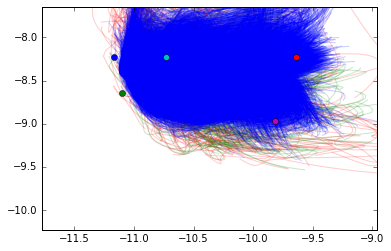

In [44]:
c3_sounds, c3_errors, c3_it = train(n_motor_babbling=250, n_goal_babbling=250, n_imitation_each=1000, explo_noise=0.05)

In [45]:
c3_it

{'euo': 629, 'ieu': 677, 'oey': 0, 'oiy': 667, 'uie': 347, 'uyi': 26}

In [ ]:
import itertools
def min_dist(human_sounds):
    
    
    v_o = list(np.log2([500, 900]))
    v_y = list(np.log2([300, 1700]))
    v_u = list(np.log2([300, 800]))
    v_e = list(np.log2([400, 2200]))
    v_i = list(np.log2([300, 2300]))


    vowels = dict(o=v_o, y=v_y, u=v_u, e=v_e, i=v_i)    

    def compute_s_sound(sound):
        s1 = vowels[sound[0]]
        s2 = [(vowels[sound[0]][0] + vowels[sound[1]][0]) / 2., (vowels[sound[0]][1] + vowels[sound[1]][1]) / 2.]
        s3 = vowels[sound[1]]
        s4 = [(vowels[sound[1]][0] + vowels[sound[2]][0]) / 2., (vowels[sound[1]][1] + vowels[sound[2]][1]) / 2.]
        s5 = vowels[sound[2]]
        rdm = 0.0 * (2.*np.random.random((1,10))[0] - 1.)
        return list(rdm + np.array([f[0] for f in [s1, s2, s3, s4, s5]] + [f[1] for f in [s1, s2, s3, s4, s5]]))


    human_sounds_traj = dict()
    for hs in human_sounds:
        human_sounds_traj[hs] = compute_s_sound(hs)
            
    min_d = 2.
    for ihs1 in range(6):
        for ihs2 in range(ihs1+1, 6):
            hs1 = human_sounds[ihs1]
            hs2 = human_sounds[ihs2]
            d = np.linalg.norm(np.array(human_sounds_traj[hs1]) - 
                               np.array(human_sounds_traj[hs2]))
            #print hs1, hs2, d
            if d < min_d:
                min_d = d
    return min_d


sounds = ["oie", "oei", "oey", "oye", "oiy", "oyi", "uie", "uei", "uey", "uye", "uiy", "uyi", 
    "ieo", "ieu", "iyo", "iyu", "iou", "iuo",
    "eio", "eiu", "eyo", "eyu", "eou", "euo", 
    "yio", "yiu", "yeo", "yeu", "you", "yuo"]

max_min_d = 0.
best_sounds = []

it = itertools.combinations(sounds, 6)

try:
    while True:
        hs = list(next(it))
        min_d = min_dist(hs)
        if min_d > max_min_d:
            max_min_d = min_d
            best_sounds = hs
except:
    print max_min_d
    print best_sounds
    
#1.26428500985
#['oey', 'uye', 'iuo', 'eyu', 'eou', 'yeo']


best_vocal_errors [('uye', 0.84119054672894222), ('iuo', 0.68061893635736048), ('eou', 0.78513565826714471), ('oey', 0.65748229048851126), ('yeo', 0.63243876283507583), ('eyu', 0.83843883767775873)]

----------------
Agent Statistics
----------------

#Iterations: 1000

# Chosen module mod1 : 0
# Chosen module mod2 : 0
# Chosen module mod3 : 0
# Chosen module mod4 : 0
# Chosen module mod5 : 0
# Chosen module mod6 : 0
# Chosen module mod10 : 0
# Chosen module mod11 : 0
# Chosen module mod12 : 0
# Chosen module mod13 : 0

Competence progress of mod1  :  0.0
Competence progress of mod2  :  0.0
Competence progress of mod3  :  0.0
Competence progress of mod4  :  0.0
Competence progress of mod5  :  0.0
Competence progress of mod6  :  0.0
Competence progress of mod10 :  0.0
Competence progress of mod11 :  0.0
Competence progress of mod12 :  0.0
Competence progress of mod13 :  0.0

Prediction progress of mod1  :  0.0
Prediction progress of mod2  :  0.0
Prediction progress of mod3  :  0.0
Predi

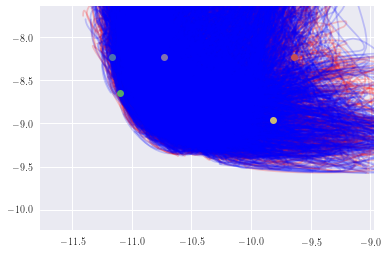

In [9]:
_, _, _, s_traj_mb_list, s_traj_gb_list, s_traj_im_list = train(n_motor_babbling=2000, n_goal_babbling=0, n_imitation_each=500, explo_noise=0.05)

In [5]:
print len(s_traj_mb_list)
print len(s_traj_gb_list)
print len(s_traj_im_list)

200
200
120


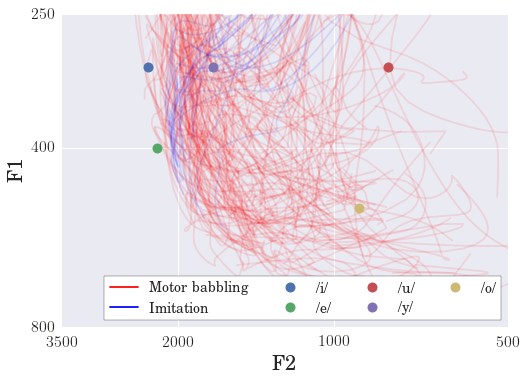

In [8]:
%matplotlib inline
import seaborn as sns
import numpy as np


plt.rc('text', usetex=True)
plt.rc('font', family='serif')

for s_traj in s_traj_mb_list[:50]:
    if np.all(s_traj):
        plt.loglog([f[1] for f in s_traj], [f[0] for f in s_traj], color="r", alpha=0.1)
plt.loglog([f[1] for f in s_traj_mb_list[0]], [f[0] for f in s_traj_mb_list[0]], color="r", alpha=0., label="Motor babbling")

for s_traj in s_traj_im_list[0:50]:
    if np.all(s_traj):
        plt.loglog([f[1] for f in s_traj], [f[0] for f in s_traj], color="b", alpha=0.1)
plt.loglog([f[1] for f in s_traj_im_list[0]], [f[0] for f in s_traj_im_list[0]], color="b", alpha=0., label="Imitation")

plt.xlim([np.log2([3500.]), np.log2([500.])])
plt.ylim([np.log2([800.]), np.log2([250.])])
    
for v in vowels.keys():
    p = plt.plot(vowels[v][1], vowels[v][0], "o", label="/" + v + "/", markersize=10)
    #color = p[0].get_color()
    #plt.plot(vowels[v][1], vowels[v][0], "o", color=color, markeredgecolor=color, markersize=30, markeredgewidth=1, markerfacecolor='None')
    
plt.gcf().set_size_inches(8., 6., forward=True)

legend = plt.legend(frameon=True, fontsize=14, ncol=4, loc="lower right")
plt.xlabel("F2", fontsize=20)
plt.ylabel("F1", fontsize=20)

plt.xticks([np.log2([3500.]), np.log2([2000.]), np.log2([1000.]), np.log2([500.])], 
           ["$3500$", "$2000$", "$1000$", "$500$"], fontsize = 16)
plt.yticks([np.log2([800.]), np.log2([400.]), np.log2([250.])], 
           ["$800$", "$400$", "$250$"], fontsize = 16)
plt.yticks(fontsize = 16)

frame = legend.get_frame()
frame.set_facecolor('1.')
frame.set_edgecolor('0.')

for l in legend.get_lines():
    l.set_alpha(1)
    
plt.gca().set_aspect('equal')

plt.savefig('../figs/fig_vocal_traj.pdf', format='pdf', bbox_inches='tight')

In [7]:
env.human_sounds

['uye', 'iuo', 'eou', 'oey', 'yeo', 'eyu']